## Evaluation of cea results 

In [194]:
import pandas as pd 
import os 

data_dict = {}
base_path = 'CEA_model/Block0202023'
for year in [2020, 2021, 2022]:   
    path = os.path.join(base_path, str(year), 'outputs', 'data', 'demand', 'Total_demand.csv')
    df = pd.read_csv(path)
    data_dict[year] = {
        "QH_sys0_kW" : df["QH_sys0_kW"].sum(),
        "E_sys_MWhyr": df["E_sys_MWhyr"].sum()
        }


In [195]:
# Check variable naming: 
# https://city-energy-analyst.readthedocs.io/en/latest/output_methods.html#get-thermal-network-velocity-edges-file 
# E_sys_MWhyr, End-use total electricity consumption
# QH_sys0_kW, Nominal total building heating demand.
data = df[["QH_sys0_kW", "E_sys_MWhyr"]]

data_dict


{2020: {'QH_sys0_kW': 931.1740000000001, 'E_sys_MWhyr': 213.82100000000003},
 2021: {'QH_sys0_kW': 532.368, 'E_sys_MWhyr': 212.27399999999997},
 2022: {'QH_sys0_kW': 563.944, 'E_sys_MWhyr': 212.372}}

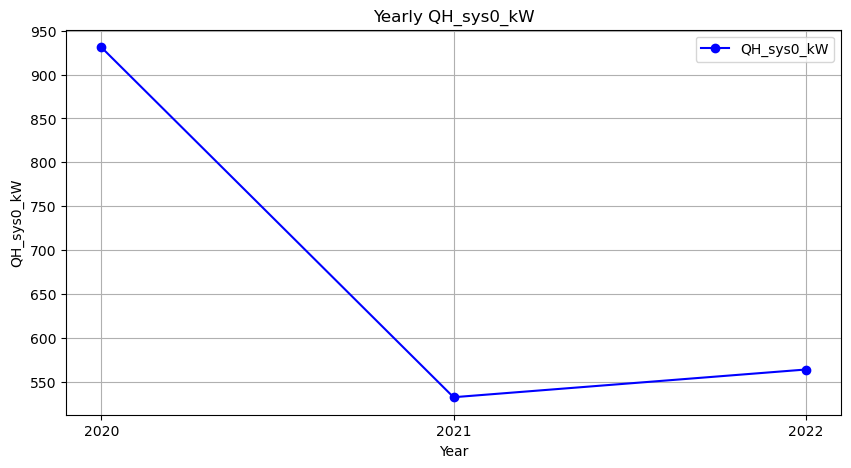

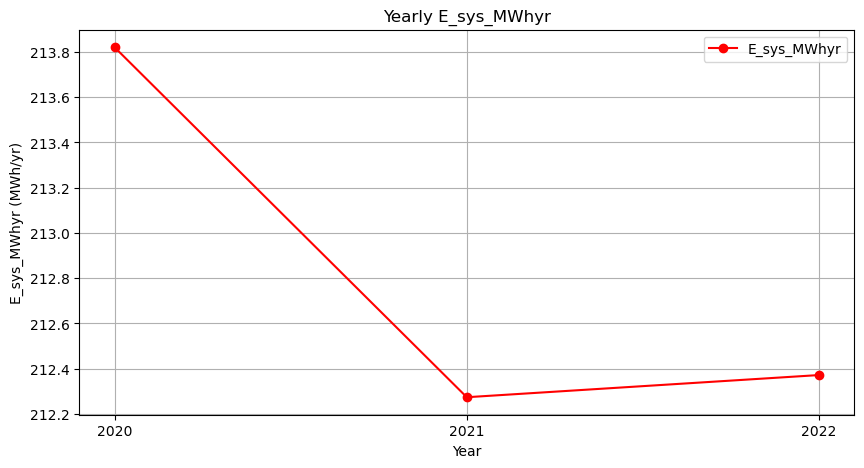

In [196]:
import matplotlib.pyplot as plt

# Provided data
# Extracting data for plotting
years = list(data_dict.keys())
qhsys0_kw_values = [data_dict[year]['QH_sys0_kW'] for year in years]
esys_mwhyr_values = [data_dict[year]['E_sys_MWhyr'] for year in years]

# Plotting QH_sys0_kW
plt.figure(figsize=(10, 5))
plt.plot(years, qhsys0_kw_values, marker='o', linestyle='-', color='blue', label='QH_sys0_kW')
plt.title('Yearly QH_sys0_kW')
plt.xlabel('Year')
plt.ylabel('QH_sys0_kW')
plt.xticks(years)
plt.grid(True)
plt.legend()

# Showing the first plot
plt.show()

# Plotting E_sys_MWhyr
plt.figure(figsize=(10, 5))
plt.plot(years, esys_mwhyr_values, marker='o', linestyle='-', color='red', label='E_sys_MWhyr')
plt.title('Yearly E_sys_MWhyr')
plt.xlabel('Year')
plt.ylabel('E_sys_MWhyr (MWh/yr)')
plt.xticks(years)
plt.grid(True)
plt.legend()

# Showing the second plot
plt.show()


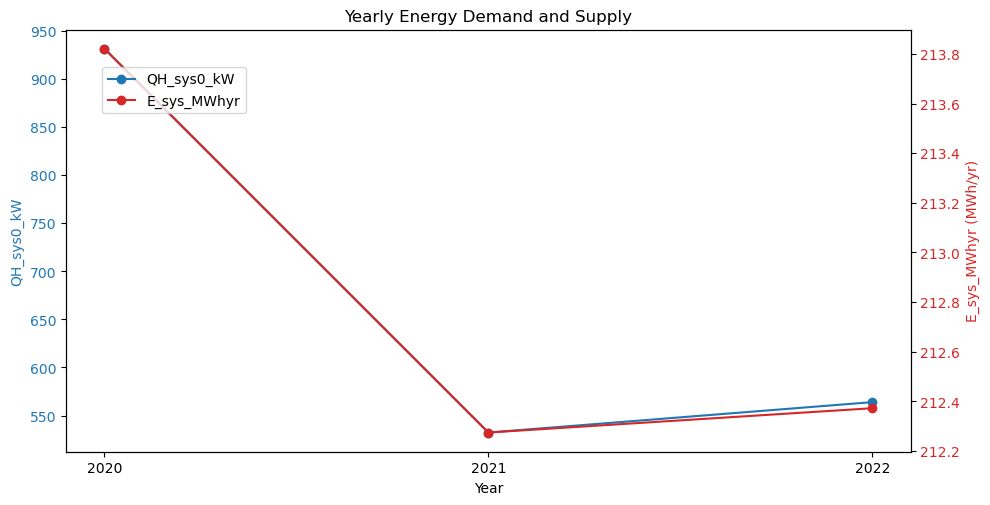

In [197]:
import matplotlib.pyplot as plt

# Provided data

# Extracting data for plotting
years = list(data_dict.keys())
qhsys0_kw_values = [data_dict[year]['QH_sys0_kW'] for year in years]
esys_mwhyr_values = [data_dict[year]['E_sys_MWhyr'] for year in years]

# Creating the plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting QH_sys0_kW with ax1
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('QH_sys0_kW', color=color)
ax1.plot(years, qhsys0_kw_values, marker='o', linestyle='-', color=color, label='QH_sys0_kW')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(years)

# Creating a second y-axis for E_sys_MWhyr
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('E_sys_MWhyr (MWh/yr)', color=color)  # we already handled the x-label with ax1
ax2.plot(years, esys_mwhyr_values, marker='o', linestyle='-', color=color, label='E_sys_MWhyr')
ax2.tick_params(axis='y', labelcolor=color)

# Final touches
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Yearly Energy Demand and Supply')
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Showing the plot
plt.show()


In [198]:
# Get real data for comparison
# Block: 
elec_path = os.path.join('auxillary', 'Elec_Berlin_2020_2022.xls')
elec_data = pd.read_excel(elec_path)
elec_data

,Blocknummer,Stromverbrauch 2022 [MWh],Hinweis 2022,Stromverbrauch 2021 [MWh],Hinweis 2021,Stromverbrauch 2020 [MWh],Hinweis 2020
0,46079,813.544,-,840.854,-,1076.908,-
1,24177,672.709,-,686.236,-,757.085,-
2,177079,10.313,-,-,Der Verbrauch wird aus Datenschutzgründen nich...,-,Der Verbrauch wird aus Datenschutzgründen nich...
3,39616,106.652,-,116.708,-,111.691,-
4,67643,826.085,-,841.998,-,771.151,-
...,...,...,...,...,...,...,...
16385,78228,100.213,-,101.961,-,98.007,-
16386,74501,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar
16387,187017,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar
16388,74128,375.105,-,379.125,-,355.516,-


In [199]:
filtered_df = elec_data[elec_data["Blocknummer"] == 20030]

In [200]:
real_esys_mwhyr = {
    2020: filtered_df["Stromverbrauch 2020 [MWh]"],
    2021 : filtered_df["Stromverbrauch 2021 [MWh]"],
    2022: filtered_df["Stromverbrauch 2022 [MWh]"]
}
real_esys_mwhyr

{2020: 13658    261.133
 Name: Stromverbrauch 2020 [MWh], dtype: object,
 2021: 13658    267.326
 Name: Stromverbrauch 2021 [MWh], dtype: object,
 2022: 13658    249.643
 Name: Stromverbrauch 2022 [MWh], dtype: object}

In [201]:
# Get real data for comparison
# Block: 
gas_path = os.path.join('auxillary', 'Gas_Berlin_2020_2022.xls')
gas_data = pd.read_excel(gas_path)
gas_data



,Blocknummer,Gasverbrauch 2022 [MWh],Hinweis 2022,Gasverbrauch 2021 [MWh],Hinweis 2021,Gasverbrauch 2020 [MWh],Hinweis 2020
0,46079,1227.315,-,1550.742,-,1385.74,-
1,24177,-,Der Verbrauch wird aus Datenschutzgründen nich...,-,Der Verbrauch wird aus Datenschutzgründen nich...,-,Der Verbrauch wird aus Datenschutzgründen nich...
2,177079,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar
3,39616,188.53,-,235.887,-,213.771,-
4,67643,2832.118,-,3333.315,-,2990.835,-
...,...,...,...,...,...,...,...
16385,78228,-,Der Verbrauch wird aus Datenschutzgründen nich...,-,Der Verbrauch wird aus Datenschutzgründen nich...,-,Der Verbrauch wird aus Datenschutzgründen nich...
16386,74501,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar
16387,187017,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar
16388,74128,991.891,-,1052.222,-,937.367,-


In [202]:
filtered_gas = gas_data[gas_data["Blocknummer"] == 20030]
gas_mwhyr = {
    2020: filtered_gas["Gasverbrauch 2022 [MWh]"],
    2021 : filtered_gas["Gasverbrauch 2021 [MWh]"],
    2022: filtered_gas["Gasverbrauch 2020 [MWh]"]
}
gas_mwhyr

{2020: 13660    38.353
 Name: Gasverbrauch 2022 [MWh], dtype: object,
 2021: 13660    40.327
 Name: Gasverbrauch 2021 [MWh], dtype: object,
 2022: 13660    38.129
 Name: Gasverbrauch 2020 [MWh], dtype: object}

In [203]:
# Get real data for comparison
# Block: 
dh_path = os.path.join('auxillary', 'DH_Berlin_2020_2022.xls')
dh_data = pd.read_excel(dh_path)


In [204]:
dh_data 

,Blocknummer,Fernwärmeverbrauch 2022 [MWh],Fernwärmeverbrauch 2021 [MWh],Fernwärmeverbrauch 2020 [MWh]
0,1001,-,-,-
1,1002,-,-,-
2,1007,2568.032,2786.803,2684.242
3,1010,-,-,-
4,1012,1305.403,1432.731,1444.354
...,...,...,...,...
16385,195634,-,-,-
16386,195635,-,-,-
16387,195901,-,-,-
16388,195902,-,-,-


In [205]:
dh_data_filtered = dh_data[dh_data["Blocknummer"] == 20030]

In [206]:
dh_mwhyr = {
    2020: dh_data_filtered["Fernwärmeverbrauch 2020 [MWh]"],
    2021 : dh_data_filtered["Fernwärmeverbrauch 2021 [MWh]"],
    2022: dh_data_filtered["Fernwärmeverbrauch 2022 [MWh]"]
}
dh_mwhyr

{2020: 1021    1530.479
 Name: Fernwärmeverbrauch 2020 [MWh], dtype: object,
 2021: 1021    1732.497
 Name: Fernwärmeverbrauch 2021 [MWh], dtype: object,
 2022: 1021    1484.434
 Name: Fernwärmeverbrauch 2022 [MWh], dtype: object}

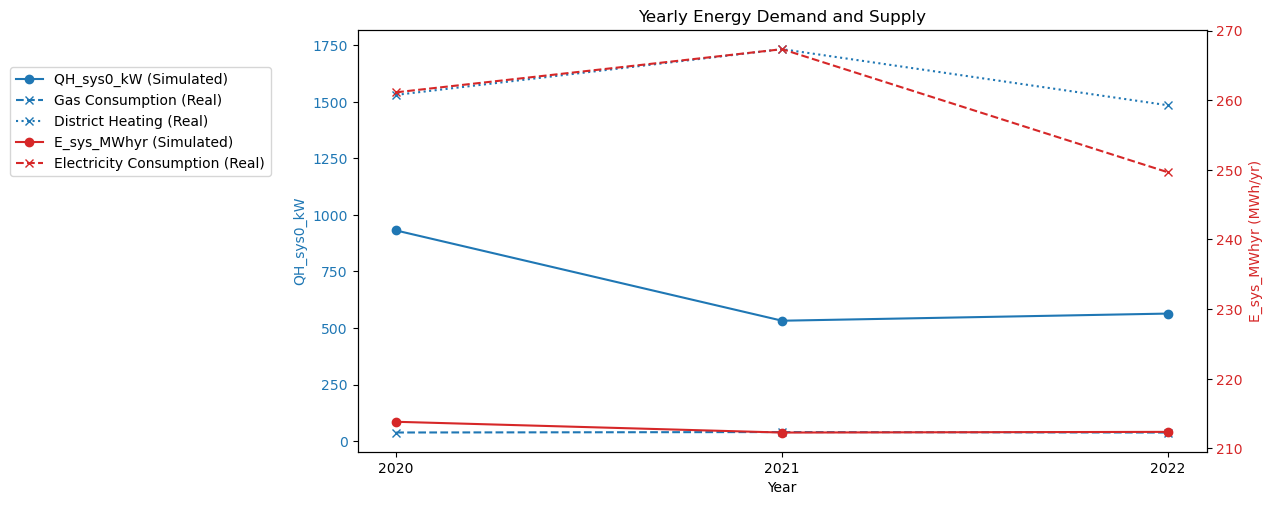

In [207]:
import matplotlib.pyplot as plt


# Extracting data for plotting
years = list(data_dict.keys())
qhsys0_kw_values = [data_dict[year]['QH_sys0_kW'] for year in years]
esys_mwhyr_values = [data_dict[year]['E_sys_MWhyr'] for year in years]
real_esys_mwhyr_values = [real_esys_mwhyr[year] for year in years]  # Use the real data extracted
real_gas_data = [gas_mwhyr[year] for year in years]
real_dh_data = [dh_mwhyr[year] for year in years]


# Creating the plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting QH_sys0_kW with ax1
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('QH_sys0_kW', color=color)
ax1.plot(years, qhsys0_kw_values, marker='o', linestyle='-', color=color, label='QH_sys0_kW (Simulated)')
ax1.plot(years, real_gas_data, marker="x", linestyle='--', color='tab:blue', label='Gas Consumption (Real)')
ax1.plot(years, real_dh_data, marker='x', linestyle=':', color='tab:blue', label='District Heating (Real)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(years)

# Creating a second y-axis for E_sys_MWhyr
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('E_sys_MWhyr (MWh/yr)', color=color)
ax2.plot(years, esys_mwhyr_values, marker='o', linestyle='-', color=color, label='E_sys_MWhyr (Simulated)')
ax2.plot(years, real_esys_mwhyr_values, marker='x', linestyle='--', color='tab:red', label='Electricity Consumption (Real)')
ax2.tick_params(axis='y', labelcolor=color)

# Final touches
fig.tight_layout()
plt.title('Yearly Energy Demand and Supply')
fig.legend( bbox_to_anchor=(0.0, 0.9))

# Showing the plot
plt.show()



In [208]:
real_gas_data, real_dh_data

([13660    38.353
  Name: Gasverbrauch 2022 [MWh], dtype: object,
  13660    40.327
  Name: Gasverbrauch 2021 [MWh], dtype: object,
  13660    38.129
  Name: Gasverbrauch 2020 [MWh], dtype: object],
 [1021    1530.479
  Name: Fernwärmeverbrauch 2020 [MWh], dtype: object,
  1021    1732.497
  Name: Fernwärmeverbrauch 2021 [MWh], dtype: object,
  1021    1484.434
  Name: Fernwärmeverbrauch 2022 [MWh], dtype: object])